# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [3]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [4]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [5]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [13]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
print(f"\n[Income]")
print(f"산술평균: {df['Income'].mean()}")
print(f"중앙값: {df['Income'].median()}")
print(f"최빈값: {df['Income'].mode().values}")
print(f"10% 절사평균: {stats.trim_mean(df['Income'], 0.05)}")

print(f"\n[Total_Spending]")
print(f"산술평균: {df['Total_Spending'].mean()}")
print(f"중앙값: {df['Total_Spending'].median()}")
print(f"최빈값: {df['Total_Spending'].mode().values}")
print(f"10% 절사평균: {stats.trim_mean(df['Total_Spending'], 0.05)}")

print(f"\n[Age]")
print(f"산술평균: {df['Age'].mean()}")
print(f"중앙값: {df['Age'].median()}")
print(f"최빈값: {df['Age'].mode().values}")
print(f"10% 절사평균: {stats.trim_mean(df['Age'], 0.05)}")


[Income]
산술평균: 51952.61404293381
중앙값: 51381.5
최빈값: [51381.5]
10% 절사평균: 51740.153426017874

[Total_Spending]
산술평균: 605.9865831842576
중앙값: 396.5
최빈값: [46]
10% 절사평균: 561.1196623634559

[Age]
산술평균: 55.10196779964222
중앙값: 54.0
최빈값: [48]
10% 절사평균: 55.074975173783514


In [14]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
df_Income_and_Total_spending_and_Age = pd.DataFrame({
    '통계량':['분산','표준편차','범위','IQR'],
    'Income':[df['Income'].var(), df['Income'].std(), df['Income'].max()-df['Income'].min(), df['Income'].quantile(0.75)-df['Income'].quantile(0.25)],
    'Total_Spending':[df['Total_Spending'].var(), df['Total_Spending'].std(), df['Total_Spending'].max()-df['Total_Spending'].min(), df['Total_Spending'].quantile(0.75)-df['Total_Spending'].quantile(0.25)],
    'Age':[df['Age'].var(), df['Age'].std(), df['Age'].max()-df['Age'].min(), df['Age'].quantile(0.75)-df['Age'].quantile(0.25)]
})
display(df_Income_and_Total_spending_and_Age)

,통계량,Income,Total_Spending,Age
0,분산,4.584509e+08,362241.666039,136.966779
1,표준편차,2.141147e+04,601.865156,11.703281
2,범위,1.606670e+05,2520.000000,56.000000
3,IQR,3.277325e+04,976.500000,18.000000


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

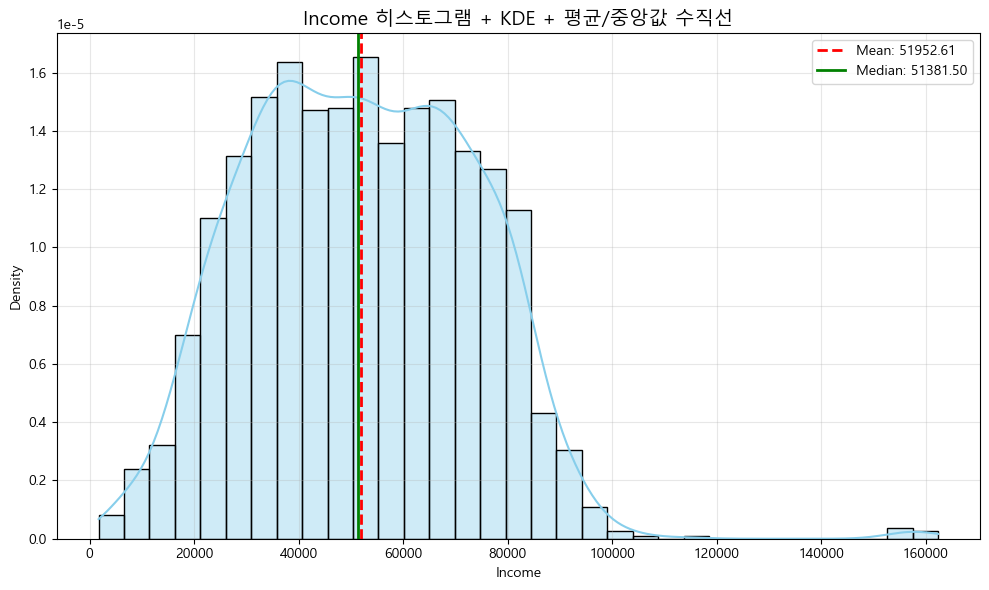

In [21]:
# TODO 1-2(a): Income 히스토그램 + KDE
import matplotlib.pyplot as plt
import seaborn as sns

mean_val = df["Income"].mean()
median_val = df["Income"].median()
skew_ness = df["Income"].skew()
kurt_ness = df["Income"].kurt()

plt.figure(figsize=(10, 6))

sns.histplot(df["Income"], kde=True, color='skyblue', stat="density", alpha=0.4)

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

plt.title(f'Income 히스토그램 + KDE + 평균/중앙값 수직선', fontsize=14)
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

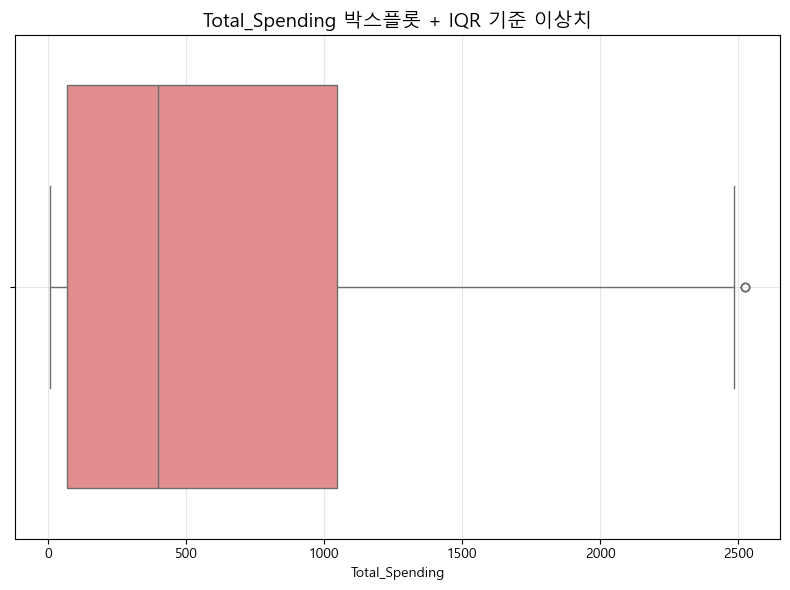

In [20]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["Total_Spending"], color='lightcoral')
plt.title('Total_Spending 박스플롯 + IQR 기준 이상치', fontsize=14)
plt.xlabel('Total_Spending')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

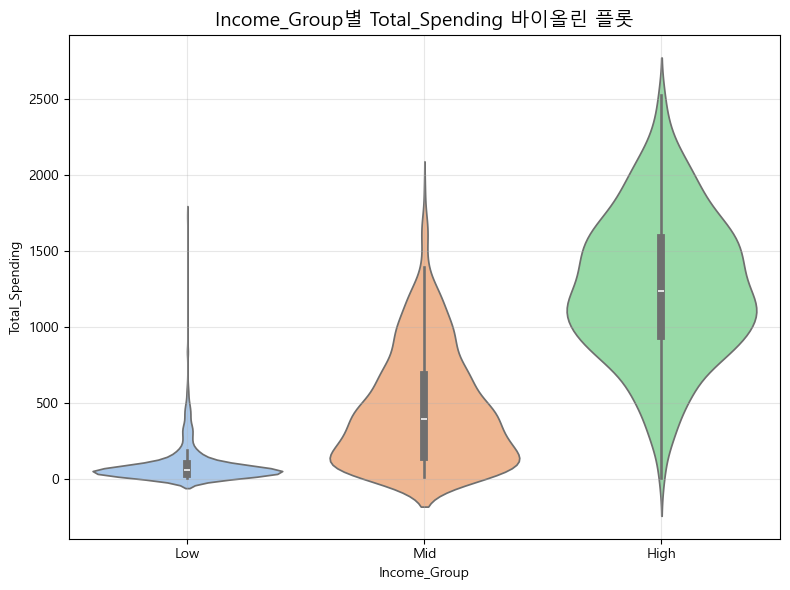

In [22]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
plt.figure(figsize=(8, 6))
sns.violinplot(x='Income_Group', y='Total_Spending', data=df, palette='pastel')
plt.title(f'Income_Group별 Total_Spending 바이올린 플롯', fontsize=14)
plt.xlabel('Income_Group')
plt.ylabel('Total_Spending')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [25]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
print("\n[6개 소비 카테고리의 왜도/첨도]")
for col in spending_cols:
    skewness = df[col].skew()
    kurtosis = df[col].kurt()
    print(f"{col}: 왜도={skewness}, 첨도={kurtosis}")


[6개 소비 카테고리의 왜도/첨도]
MntWines: 왜도=1.1760359853075724, 첨도=0.6005314639884163
MntFruits: 왜도=2.1042414439645296, 첨도=4.06975425085383
MntMeatProducts: 왜도=2.0852824286336658, 첨도=5.530135658905085
MntFishProducts: 왜도=1.9199695762608637, 첨도=3.09602040234761
MntSweetProducts: 왜도=2.135674110666548, 첨도=4.372061860782441
MntGoldProds: 왜도=1.8851362496436508, 첨도=3.5583489498611462


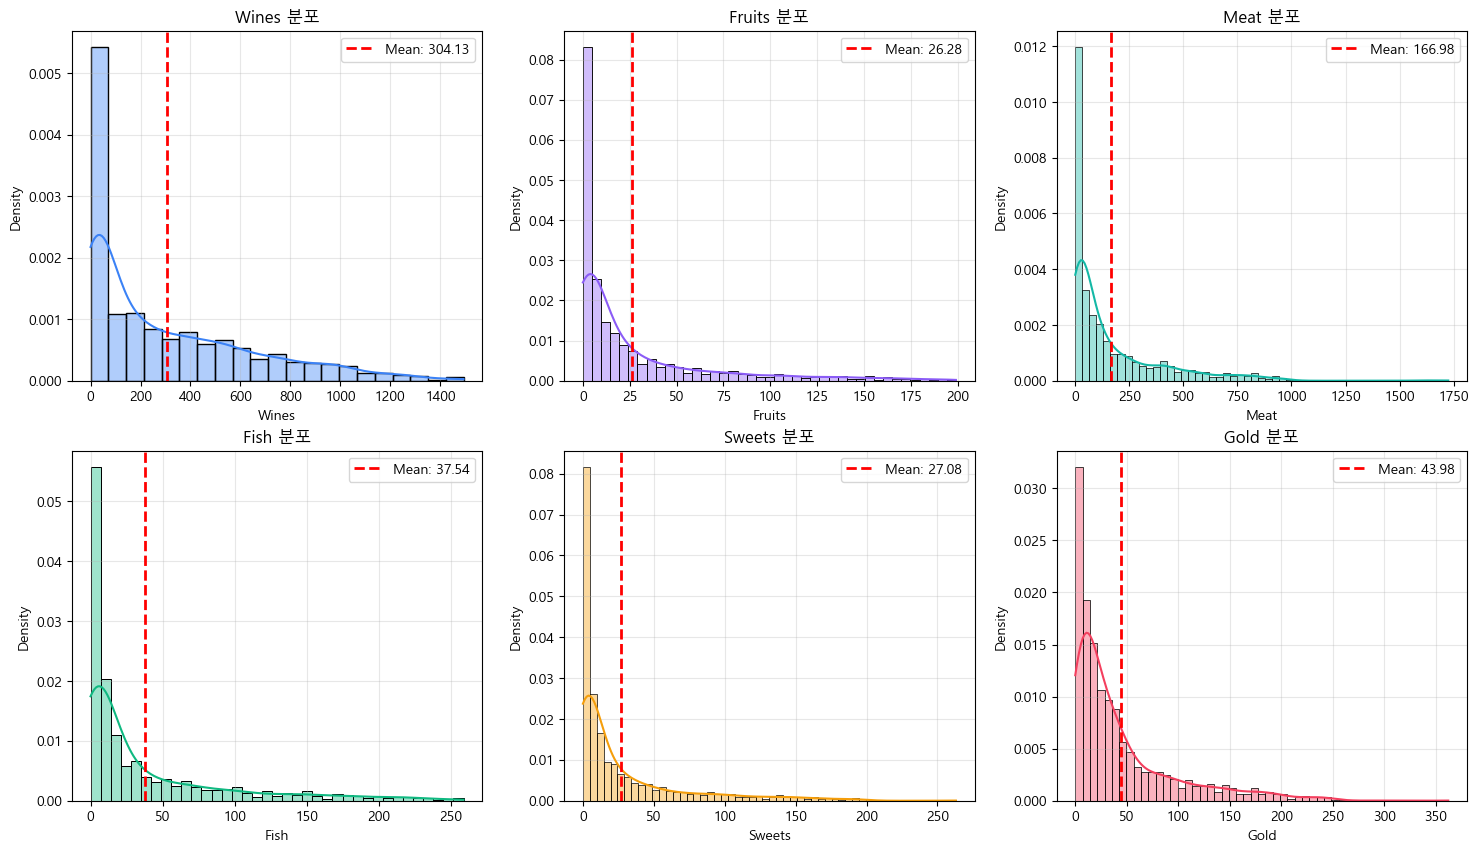

In [27]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(spending_cols):
    row, col_idx = divmod(i, 3)
    sns.histplot(df[col], kde=True, color=hist_colors[i], stat="density", alpha=0.4, ax=axes[row][col_idx])
    mean_val = df[col].mean()
    axes[row][col_idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[row][col_idx].set_title(f'{spending_names[i]} 분포', fontsize=12)
    axes[row][col_idx].set_xlabel(spending_names[i])
    axes[row][col_idx].set_ylabel('Density')
    axes[row][col_idx].legend()
    axes[row][col_idx].grid(True, alpha=0.3)

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [ ]:
# TODO 1-4: 비즈니스 인사이트 정리

---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [42]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10

# 수락율(p) 계산
success = df['Response'].value_counts()
success = success.get(1, 0) 
p = success / len(df)
print(f"수락율 p = {p}")

binom_dist = stats.binom(n_trial, p)

# P(X=2) 계산
prob_x2 = binom_dist.pmf(2)
print(f"P(X=2) = {prob_x2}")

# P(X≥3) 계산
prob_x_ge_3 = binom_dist.sf(2)
print(f"P(X≥3) = {prob_x_ge_3}")

수락율 p = 0.14937388193202147
P(X=2) = 0.27521465499368963
P(X≥3) = 0.17818029736723678


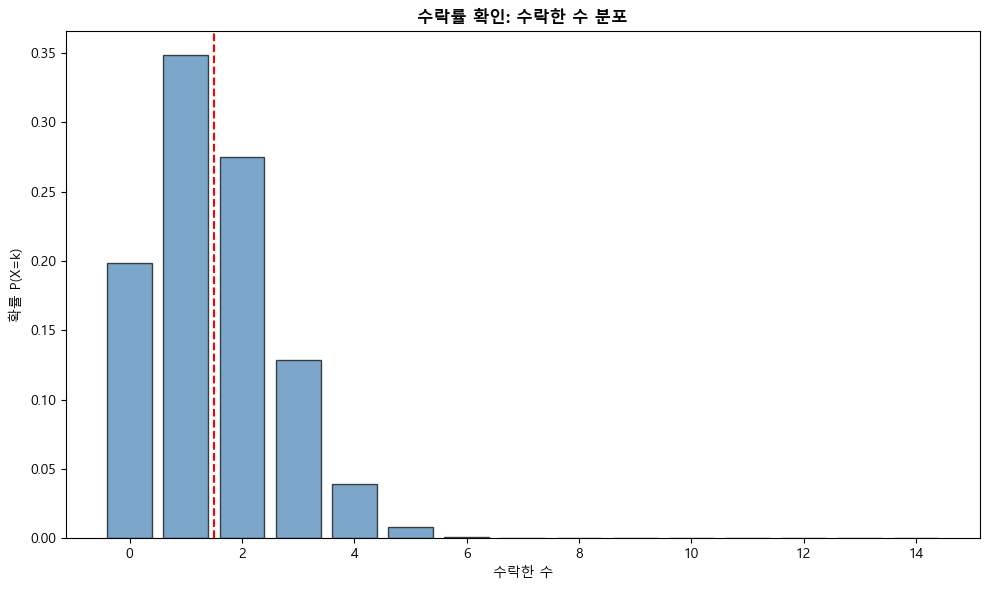

In [44]:
# TODO 2-1(c): 이항분포 PMF 시각화
expected_value = binom_dist.mean()
std_dev = binom_dist.std()

fig, ax = plt.subplots(figsize=(10, 6))

k = np.arange(0, 15)
pmf = binom_dist.pmf(k)
ax.bar(k, pmf, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(expected_value, color='red', linestyle='--',
                label=f'기대값 = {expected_value:.1f}')
ax.set_xlabel('수락한 수')
ax.set_ylabel('확률 P(X=k)')
ax.set_title('수락률 확인: 수락한 수 분포', fontweight='bold')

plt.tight_layout()
plt.show()

In [45]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

# 기대 수락자
expected_yes = n_campaign * p
print(f"100명 발송 시 기대 수락자: {expected_yes}")

# P(X≥15)
p_at_least_15 = binom_dist.sf(14)
print(f"P(X≥15) = {p_at_least_15}")

# 90% 보장 최소 수락 수
capacity_90 = binom_dist.ppf(0.90)
print(f"90% 보장 최소 수락 수: {capacity_90}")

100명 발송 시 기대 수락자: 14.937388193202148
P(X≥15) = 0.0
90% 보장 최소 수락 수: 3.0


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [52]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lam = web_visits.mean()
print(f"월간 웹 방문수 평균 (λ 추정값): {lam}")

var = web_visits.var()
print(f"월간 웹 방문수 분산: {var}")

# 포아송 분포 적합성 확인 (평균 ≈ 분산)
ratio = var / lam
print(f"분산/평균 비율: {ratio}")

print(f"\n평균과 분산이 유사한 것으로 보아 월간 웹 방분수 데이터는 포아송 분포를 따른다고 가정할 수 있다.")
print("비율이 1보다 살짝 큰 것으로 보아 극단치가 포함되었을 수 있다.")

월간 웹 방문수 평균 (λ 추정값): 5.318872987477639
월간 웹 방문수 분산: 5.889773404889684
분산/평균 비율: 1.1073348468286668

평균과 분산이 유사한 것으로 보아 월간 웹 방분수 데이터는 포아송 분포를 따른다고 가정할 수 있다.
비율이 1보다 살짝 큰 것으로 보아 극단치가 포함되었을 수 있다.


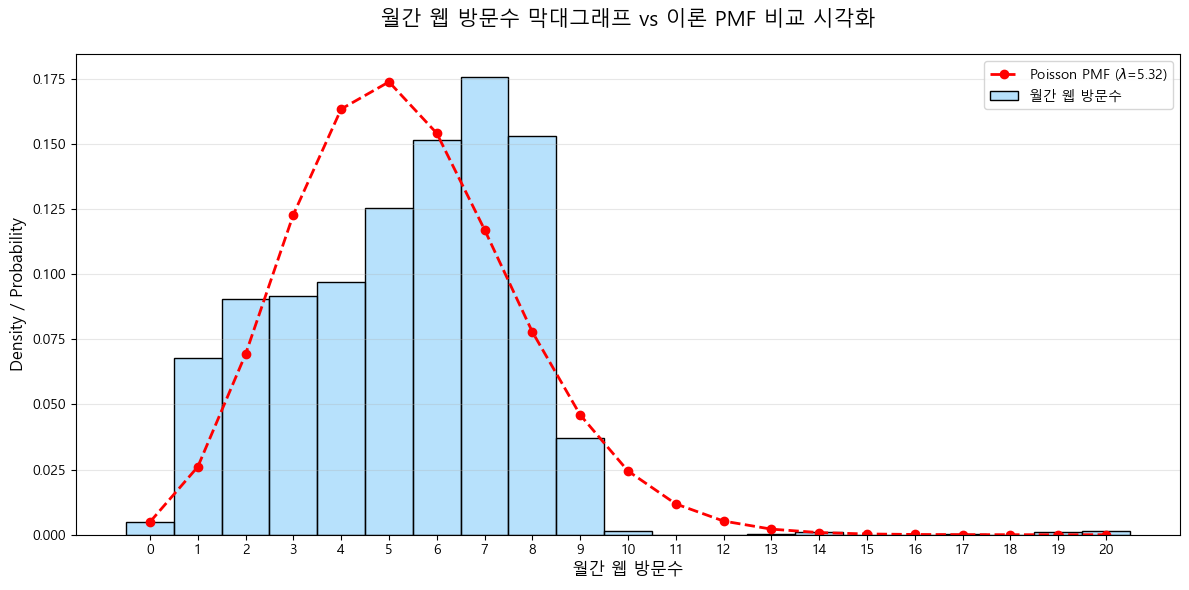

In [58]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
poisson_dist = stats.poisson(mu=lam)

plt.figure(figsize=(12, 6))
sns.histplot(web_visits, discrete=True, stat="density", color='lightskyblue', 
             alpha=0.6, label='월간 웹 방문수')
x_range = np.arange(0, web_visits.max() + 1)
poisson_pmf = poisson_dist.pmf(x_range)

plt.plot(x_range, poisson_pmf, marker='o', linestyle='--', color='red', 
         linewidth=2, label=f'Poisson PMF ($\lambda$={lam:.2f})')

plt.title('월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화', fontsize=15, pad=20)
plt.xlabel('월간 웹 방문수', fontsize=12)
plt.ylabel('Density / Probability', fontsize=12)
plt.xticks(x_range)
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

# 과다 방문 고객
p_over = poisson_dist.sf(heavy_threshold - 1)
print(f"월 10회 이상 방문할 확률 P(X ≥ {heavy_threshold}) = {p_over:.4f}")

# P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 
k = poisson_dist.ppf(0.95)
print(f"P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k: {k}")

월 10회 이상 방문할 확률 P(X ≥ 10) = 0.0449
P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k: 9.0


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [62]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

income_mu = df['Income'].mean()
income_sigma = df['Income'].std()
print(f"Income 평균(μ) 추정값: {income_mu}")
print(f"Income 표준편차(σ) 추정값: {income_sigma}")

norm_dist = stats.norm(loc=income_mu, scale=income_sigma)

# P(Income<30000)
p_less_30000 = norm_dist.cdf(30000)
print(f"P(Income<30000) = {p_less_30000}")

# P(Income>80000)
p_greater_80000 = norm_dist.sf(80000)
print(f"P(Income>80000) = {p_greater_80000}")

# 상위 10% 소득 기준값 계산
income_cutoff = norm_dist.ppf(0.90)
print(f"소득 기준 (상위 10%): {income_cutoff}")

Income 평균(μ) 추정값: 51952.61404293381
Income 표준편차(σ) 추정값: 21411.466850558867
P(Income<30000) = 0.15261702861320564
P(Income>80000) = 0.09511083952500893
소득 기준 (상위 10%): 79392.51290587384


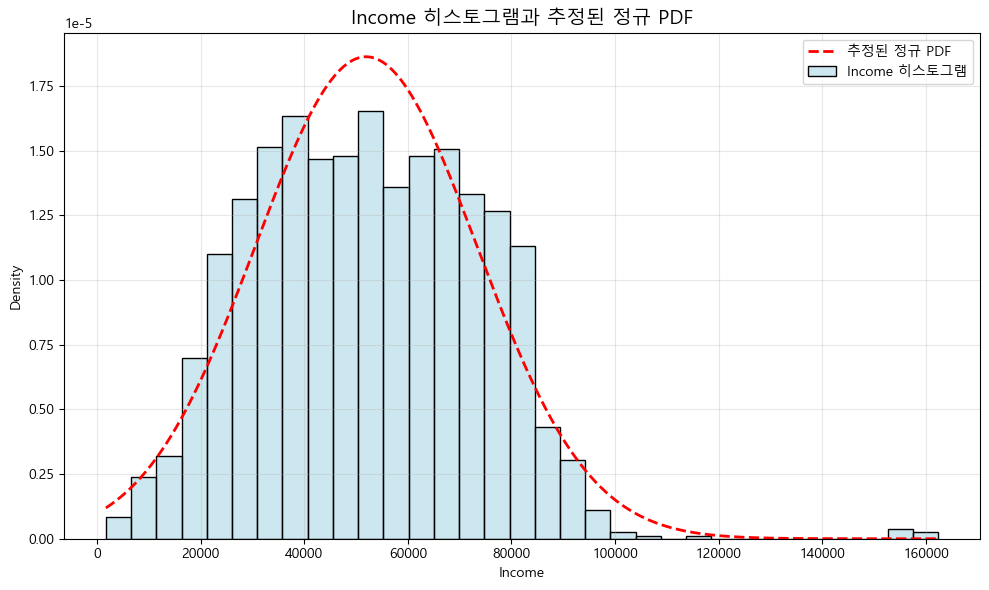

In [63]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=False, stat="density", color='lightblue', alpha=0.6, label='Income 히스토그램')
x_values = np.linspace(df['Income'].min(), df['Income'].max(), 1000)
pdf_values = norm_dist.pdf(x_values)
plt.plot(x_values, pdf_values, color='red', linestyle='--', linewidth=2, label='추정된 정규 PDF')
plt.title('Income 히스토그램과 추정된 정규 PDF', fontsize=14)
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [64]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선

# VIP(상위 5%) 기준선
vip_cutoff = norm_dist.ppf(0.95)
print(f"VIP 기준 (상위 5%): {vip_cutoff}")

# 할인 대상(하위 10%) 기준선
discount_cutoff = norm_dist.ppf(0.10)
print(f"할인 대상 기준 (하위 10%): {discount_cutoff}")

VIP 기준 (상위 5%): 87171.34295042677
할인 대상 기준 (하위 10%): 24512.715179993782


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [70]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
n = len(df['Total_Spending'])
x_bar = np.mean(df['Total_Spending'])
s = np.std(df['Total_Spending'], ddof=1)
se = s / np.sqrt(n)

levels = [0.90, 0.95, 0.99]

def confidence_interval(levels):
    for level in levels:
        ci = stats.t.interval(level, df=n-1, loc=x_bar, scale=se)
        print(f"{level*100:.0f}% 신뢰구간: {ci}")

print("\n[Total_Spending 평균의 신뢰구간]")
confidence_interval(levels)


[Total_Spending 평균의 신뢰구간]
90% 신뢰구간: (np.float64(585.0420537644019), np.float64(626.9311126041133))
95% 신뢰구간: (np.float64(581.0264644747788), np.float64(630.9467018937364))
99% 신뢰구간: (np.float64(573.1731693894566), np.float64(638.7999969790586))


Low 그룹의 95% 신뢰구간: (np.float64(27825.719108832862), np.float64(29042.417620389657))
Mid 그룹의 95% 신뢰구간: (np.float64(51082.354245402246), np.float64(52009.51958010111))
High 그룹의 95% 신뢰구간: (np.float64(75075.4180731435), np.float64(76743.39266511153))


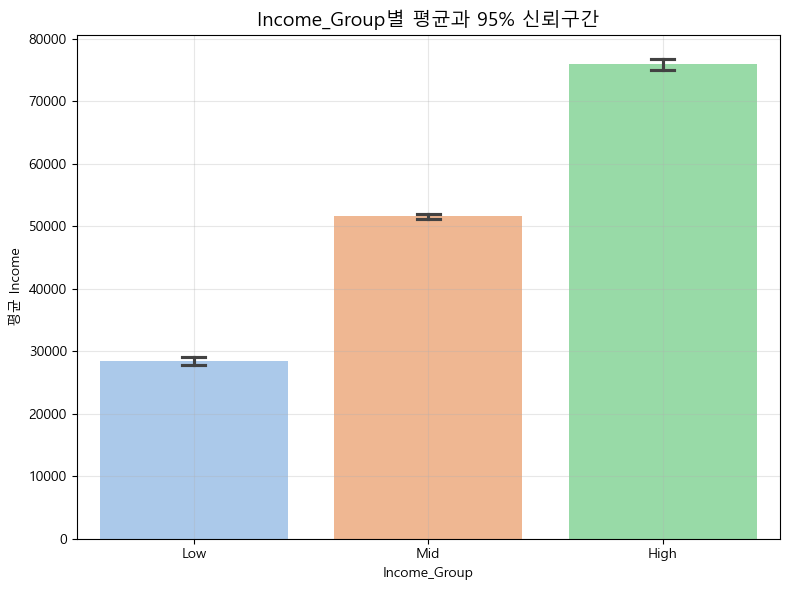

In [82]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
# Income_Group별 95% CI 계산
income_group_means = df.groupby('Income_Group')['Income'].mean()
income_group_sems = df.groupby('Income_Group')['Income'].sem()
income_group_counts = df.groupby('Income_Group')['Income'].count()
income_group = {}
for group in income_group_means.index:
    ci = stats.t.interval(0.95, df=income_group_counts[group]-1, loc=income_group_means[group], scale=income_group_sems[group])
    income_group[group] = ci
    print(f"{group} 그룹의 95% 신뢰구간: {ci}")

# 오차막대 그래프
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Income_Group', y='Income', errorbar=('ci', 95), capsize=0.1, palette='pastel')
plt.title('Income_Group별 평균과 95% 신뢰구간', fontsize=14)
plt.xlabel('Income_Group')
plt.ylabel('평균 Income')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [87]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력

# Welch's t-test
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)

# Cohen's d 계산
n1,n2 = len(no_child), len(yes_child)
s1,s2 = np.std(no_child, ddof=1), np.std(yes_child, ddof=1)

def cohens_d_ind(no_child, yes_child):
    s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
    d = abs(np.mean(no_child) - np.mean(yes_child)) / s_pooled
    return d

# Cohen's d 해석
def interpret_d(d):
    if d < 0.5:
        return "작은 효과"
    elif d < 0.8:
        return "중간 효과"
    else:
        return "큰 효과"
    
# 결과 출력
print(f"\n[Welch's t-test 결과]")
print(f"p-value: {p_value}")
print(f"유의수준 alpha(0.05) > p-value({p_value})이므로 귀무가설을 기각한다.")
print("자녀 유무에 따른 Total_Spending 평균에 유의한 차이가 있다고 볼 수 있다.")

d_ind = cohens_d_ind(no_child, yes_child)
interpret = interpret_d(d_ind)
print(f"\n[Cohen's d 결과]")
print(f"Cohen's d: {d_ind:.3f} ({interpret})")
print("효과 크기는 큰 효과 수준으로 자녕 유무가 Total_Spending에 미치는 영향이 크다고 볼 수 있다.")


[Welch's t-test 결과]
p-value: 6.321230429385628e-105
유의수준 alpha(0.05) > p-value(6.321230429385628e-105)이므로 귀무가설을 기각한다.
자녀 유무에 따른 Total_Spending 평균에 유의한 차이가 있다고 볼 수 있다.

[Cohen's d 결과]
Cohen's d: 1.360 (큰 효과)
효과 크기는 큰 효과 수준으로 자녕 유무가 Total_Spending에 미치는 영향이 크다고 볼 수 있다.


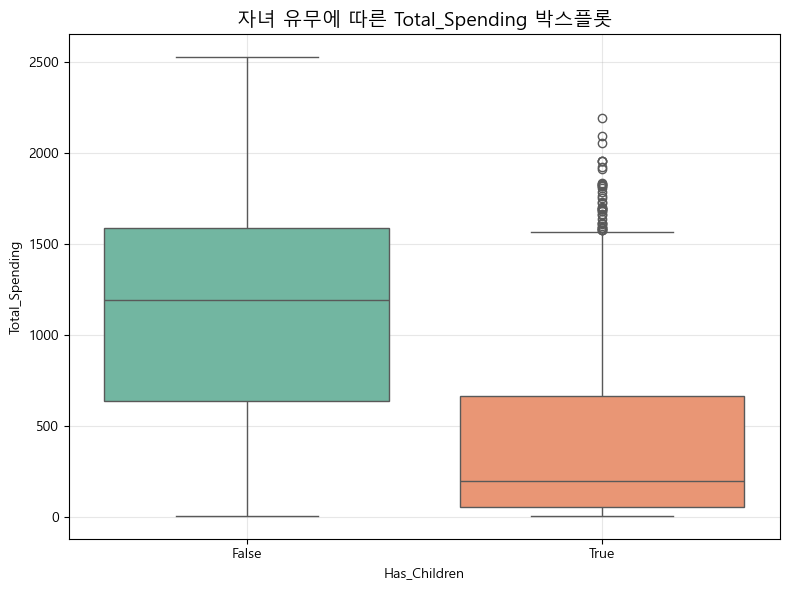

In [88]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(x='Has_Children', y='Total_Spending', data=df, palette='Set2')
plt.title('자녀 유무에 따른 Total_Spending 박스플롯', fontsize=14)
plt.xlabel('Has_Children')
plt.ylabel('Total_Spending')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [91]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
# 차이 계산
diff = wines - meat

# 대응표본 t-검정
t_stat, p_value = stats.ttest_rel(wines, meat)

# Cohen's d 계산
def cohens_d_paired(diff):
    return abs(np.mean(diff)) / np.std(diff, ddof=1)

# Cohen's d 해석
def interpret_d(d):
    if d < 0.5:
        return "작은 효과"
    elif d < 0.8:
        return "중간 효과"
    else:
        return "큰 효과"
    
# 결과 출력
print(f"\n[대응표본 t-test 결과]")
print(f"p-value: {p_value}")
print(f"유의수준 alpha(0.05) > p-value({p_value})이므로 귀무가설을 기각한다.")
print("와인과 고기 소비 금액에 유의한 차이가 있다고 볼 수 있다.")

d_rel = cohens_d_paired(diff)
interpret = interpret_d(d_rel)
print(f"\n[Cohen's d 결과]")
print(f"Cohen's d: {d_rel} ({interpret})")
print("효과 크기는 작은 효과 수준으로 와인과 고기 소비 금액의 차이가 있지만 그 크기는 작다고 볼 수 있다.")


[대응표본 t-test 결과]
p-value: 5.391926544698085e-106
유의수준 alpha(0.05) > p-value(5.391926544698085e-106)이므로 귀무가설을 기각한다.
와인과 고기 소비 금액에 유의한 차이가 있다고 볼 수 있다.

[Cohen's d 결과]
Cohen's d: 0.488362577872471 (작은 효과)
효과 크기는 작은 효과 수준으로 와인과 고기 소비 금액의 차이가 있지만 그 크기는 작다고 볼 수 있다.


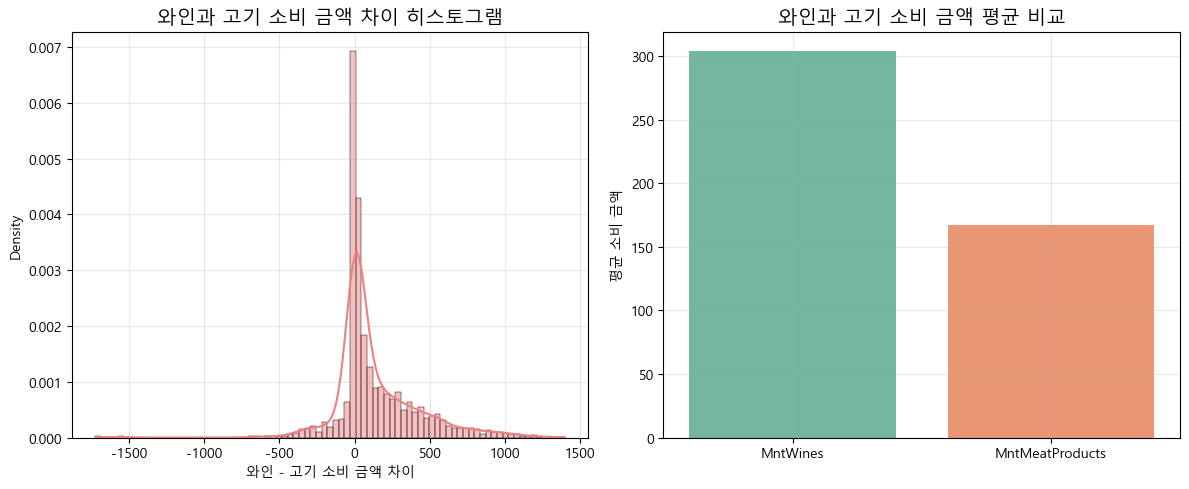

In [96]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(diff, kde=True, color='lightcoral', stat="density")
plt.title('와인과 고기 소비 금액 차이 히스토그램', fontsize=14)
plt.xlabel('와인 - 고기 소비 금액 차이')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
category_means = [wines.mean(), meat.mean()]
categories = ['MntWines', 'MntMeatProducts']
sns.barplot(x=categories, y=category_means, palette='Set2')
plt.title('와인과 고기 소비 금액 평균 비교', fontsize=14)
plt.ylabel('평균 소비 금액')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [110]:
power_analysis = TTestIndPower()

# print(d_ind) #1.3598537468445944
# print(n1) #637
# print(n2 / n1) #2.510204081632653


# TODO 3-4(a): 문제 3-2 기준 검정력 계산
power_lib = power_analysis.solve_power(
    effect_size = d_ind,
    nobs1 = n1,
    alpha = 0.05,
    ratio = n2 / n1,
    alternative = 'two-sided'
)

print(f"문제 3-2 기준 검정력 (Power): {power_lib}")

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
required_n = power_analysis.solve_power(
    effect_size = 0.2,
    alpha = 0.05,
    power = 0.8,
    alternative = 'two-sided'
)
print(f"작은 효과(d=0.2) 탐지에 필요한 최소 표본 크기 (한 그룹당): {round(required_n)}")

문제 3-2 기준 검정력 (Power): nan
작은 효과(d=0.2) 탐지에 필요한 최소 표본 크기 (한 그룹당): 393


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [ ]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
for group in edu_groups:
    stat_sw, p_sw = stats.shapiro(df[df['Education_Group'] == group]['Total_Spending'])
    print(f"그룹 {group}: Shapiro-Wilk 검정 p-value = {p_sw}")

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
group_samples = [df[df['Education_Group'] == g]['Total_Spending'] for g in edu_groups]

lev_stat, lev_p = stats.levene(*group_samples)

print(f"Levene 등분산 검정 결과: 통계량 = {lev_stat}, p-value = {lev_p}")

if lev_p < 0.05:
    use_welch = True
    print("👉 p-value < 0.05: 등분산 가정이 충족되지 않음 (이분산). Welch's ANOVA 사용")
else:
    use_welch = False
    print("👉 p-value >= 0.05: 등분산 가정이 충족됨. 일반 ANOVA 사용")

그룹 Undergraduate: Shapiro-Wilk 검정 p-value = 5.543648052614619e-19
그룹 Graduate: Shapiro-Wilk 검정 p-value = 3.561909628976696e-29
그룹 Postgraduate: Shapiro-Wilk 검정 p-value = 1.7757879312718283e-25
Levene 등분산 검정 결과: 통계량 = 13.289295744619572, p-value = 1.8306692793099772e-06
👉 p-value < 0.05: 등분산 가정이 충족되지 않음 (이분산). Welch's ANOVA 사용


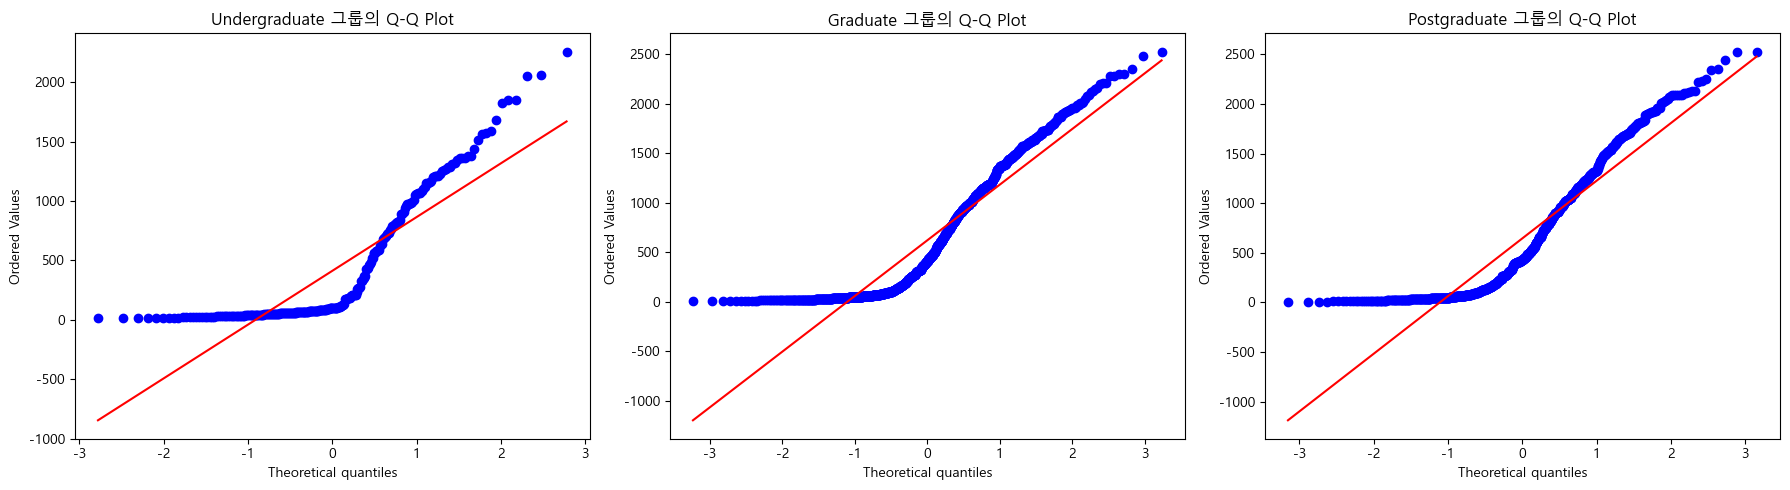

In [122]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
plt.figure(figsize=(18, 5))
for i, group in enumerate(edu_groups):
    plt.subplot(1, 3, i+1)
    stats.probplot(df[df['Education_Group'] == group]['Total_Spending'], dist="norm", plot=plt)
    plt.title(f'{group} 그룹의 Q-Q Plot', fontsize=12)
plt.tight_layout()
plt.show()  

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [134]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
## Welch's ANOVA
anova_result = pg.welch_anova(dv='Total_Spending', between='Education_Group', data=df)
print(f"Welch's ANOVA 결과:\n {anova_result}")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
all_values = np.concatenate(list(group_data.values()))
grand_mean = np.mean(all_values)
n_total = len(all_values)
k = len(group_data)

# SS_between (집단 간 제곱합)
ss_between = sum(len(v) * (np.mean(v) - grand_mean)**2 for v in group_data.values())
# SS_total (전체 제곱합)
ss_total = sum((all_values - grand_mean)**2)
# SS_within 및 MS_within 계산
ss_within = ss_total - ss_between
ms_within = ss_within / (n_total - k)

# η² (Eta-squared)
eta_sq = ss_between / ss_total

# ω² (Omega-squared) 보정 공식 적용
omega_sq = (ss_between - (k - 1) * ms_within) / (ss_total + ms_within)

print(f"\n[효과 크기 분석 결과]")
print(f"η² (Eta-squared): {eta_sq}")
print(f"ω² (Omega-squared): {omega_sq}")

Welch's ANOVA 결과:
             Source  ddof1       ddof2          F         p-unc     np2
0  Education_Group      2  751.708152  19.817377  4.098696e-09  0.0137

[효과 크기 분석 결과]
η² (Eta-squared): 0.01370028236618732
ω² (Omega-squared): 0.01281123840913712


In [145]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
g = pg.pairwise_gameshowell(dv='Total_Spending', between='Education_Group', data=df)
print(f"\n[Games-Howell 사후검정 결과]")
print(g)

# 쌍별 효과크기 계산 (Hedges' g)
from itertools import combinations

for (g1, data1), (g2, data2) in combinations(group_data.items(), 2):
    d = pg.compute_effsize(data1, data2, eftype='hedges')
    
    # 효과크기 크기 해석 (Cohen의 기준)
    abs_d = abs(d)
    if abs_d < 0.5:
        size = "작은 효과"
    elif abs_d < 0.8:
        size = "중간 효과"
    else:
        size = "큰 효과"
        
    print(f"  {g1} vs {g2}: Hedges' g = {d:.3f} ({size})")


[Games-Howell 사후검정 결과]
              A              B     mean(A)     mean(B)        diff         se  \
0      Graduate   Postgraduate  620.394316  644.791813  -24.397497  27.691976   
1      Graduate  Undergraduate  620.394316  412.254902  208.139414  36.852786   
2  Postgraduate  Undergraduate  644.791813  412.254902  232.536911  38.554847   

          T           df          pval    hedges  
0 -0.881031  1808.339544  6.523632e-01 -0.040121  
1  5.647861   425.032927  8.920656e-08  0.355688  
2  6.031328   492.811108  9.577128e-09  0.389636  
  Undergraduate vs Graduate: Hedges' g = -0.356 (작은 효과)
  Undergraduate vs Postgraduate: Hedges' g = -0.390 (작은 효과)
  Graduate vs Postgraduate: Hedges' g = -0.040 (작은 효과)


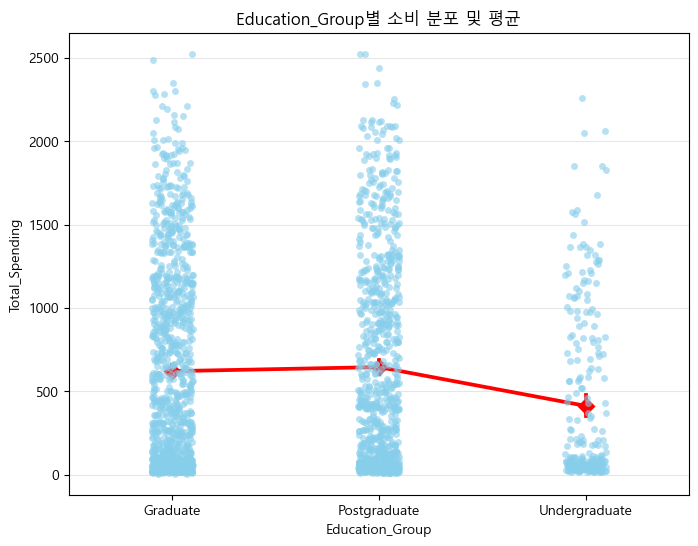

In [151]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
plt.figure(figsize=(8, 6))
sns.stripplot(x='Education_Group', y='Total_Spending', data=df, 
              color='skyblue', alpha=0.6, jitter=True)
sns.pointplot(x='Education_Group', y='Total_Spending', data=df, 
              color='red', markers='D')
plt.title('Education_Group별 소비 분포 및 평균')
plt.grid(axis='y', alpha=0.3)
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [168]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
chi2_stat, p_chi2, dof, expected = stats.chi2_contingency(crosstab_no_margin)

## Cochran 규칙 확인
expected_fisher = pd.DataFrame(
    expected, 
    index=crosstab_no_margin.index, 
    columns=crosstab_no_margin.columns
)

print(f"\n[기대빈도]")
display(expected_fisher.round(1))
print("기대빈도가 5 미만인 셀이 존재하지 않으므로 Cochran 규칙을 만족한다.")

# TODO 4-3(b): φ (phi) 계산
print(f"\n[phi 계산]")
N_f = crosstab_no_margin.sum().sum()
phi = np.sqrt(chi2_stat / N_f)
print(f"Phi 계수(φ) = {phi}")


# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
odds_ratio, fisher_p = stats.fisher_exact(crosstab_no_margin)
table = crosstab_no_margin.values
a, b, c, d = table[0, 0], table[0, 1], table[1, 0], table[1, 1]
log_or = np.log(odds_ratio)
se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)

ci_low = np.exp(log_or - 1.96 * se_log_or)
ci_high = np.exp(log_or + 1.96 * se_log_or)

print(f"\n[오즈비 및 95% 신뢰구간]")
print(f"오즈비: {odds_ratio}")
print(f"오즈비 95% CI: [{ci_low}, {ci_high}]")


[기대빈도]


Campaign_Response,False,True
Marital_Group,,
Single,578.1,215.9
Together,1049.9,392.1


기대빈도가 5 미만인 셀이 존재하지 않으므로 Cochran 규칙을 만족한다.

[phi 계산]
Phi 계수(φ) = 0.06427230766297097

[오즈비 및 95% 신뢰구간]
오즈비: 0.7395573898811642
오즈비 95% CI: [0.6105091394613098, 0.8958836118496832]


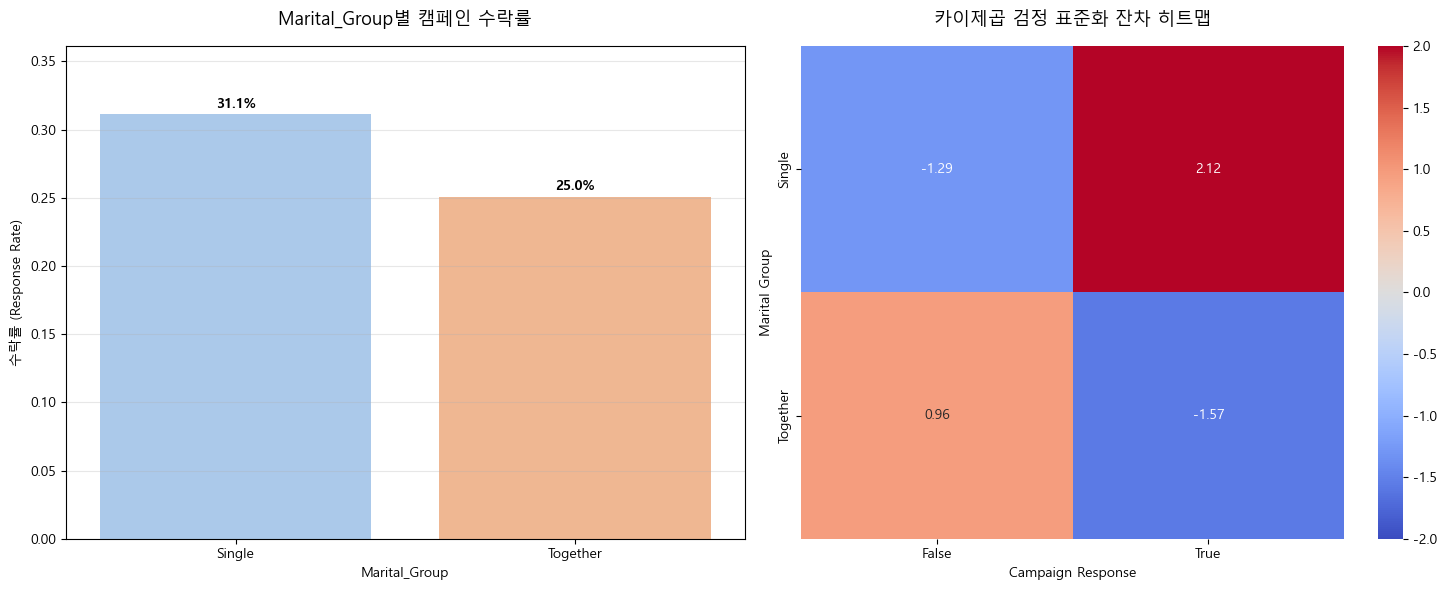

In [ ]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# (1) 결혼 상태별 반응률 막대그래프
target_col = True if True in crosstab_no_margin.columns else 'Yes'
response_rates = crosstab_no_margin.div(crosstab_no_margin.sum(axis=1), axis=0)[target_col]

sns.barplot(x=response_rates.index, y=response_rates.values, palette='pastel', ax=ax1)

for i, v in enumerate(response_rates.values):
    ax1.text(i, v + 0.005, f"{v*100:.1f}%", ha='center', fontweight='bold')

ax1.set_title('Marital_Group별 캠페인 수락률', fontsize=13, pad=15)
ax1.set_ylabel('수락률 (Response Rate)')
ax1.set_ylim(0, response_rates.max() + 0.05)
ax1.grid(True, axis='y', alpha=0.3)

# (2) 표준화 잔차 히트맵
residuals = (crosstab_no_margin - expected) / np.sqrt(expected)

sns.heatmap(residuals, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, vmin=-2, vmax=2, ax=ax2)

ax2.set_title('카이제곱 검정 표준화 잔차 히트맵', fontsize=13, pad=15)
ax2.set_xlabel('Campaign Response')
ax2.set_ylabel('Marital Group')
plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [ ]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
# TODO 4-4(b): Cohen's w 계산

In [ ]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [177]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
corr_matrix_pearson = df[corr_vars].corr(method='pearson')
print("\nPearson 상관행렬:")
display(corr_matrix_pearson.round(4))

corr_matrix_spearman = df[corr_vars].corr(method='spearman')
print("\nSpearman 상관행렬:")
display(corr_matrix_spearman.round(4))

# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
for var1, var2 in combinations(corr_vars, 2):
    r, p = stats.pearsonr(df[var1], df[var2])
    print(f"{var1} vs {var2}: r = {r}, p-value = {p}")


Pearson 상관행렬:


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.0000,0.1988,0.7894,0.7386,-0.6464,0.0078
Age,0.1988,1.0000,0.1136,0.1730,-0.1175,0.0194
Total_Spending,0.7894,0.1136,1.0000,0.8211,-0.4999,0.0208
Total_Purchases,0.7386,0.1730,0.8211,1.0000,-0.4267,0.0064
NumWebVisitsMonth,-0.6464,-0.1175,-0.4999,-0.4267,1.0000,-0.0218
Recency,0.0078,0.0194,0.0208,0.0064,-0.0218,1.0000



Spearman 상관행렬:


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.0000,0.2165,0.8495,0.7768,-0.6403,0.0097
Age,0.2165,1.0000,0.1577,0.1793,-0.1294,0.0201
Total_Spending,0.8495,0.1577,1.0000,0.9084,-0.4768,0.0200
Total_Purchases,0.7768,0.1793,0.9084,1.0000,-0.4209,0.0117
NumWebVisitsMonth,-0.6403,-0.1294,-0.4768,-0.4209,1.0000,-0.0223
Recency,0.0097,0.0201,0.0200,0.0117,-0.0223,1.0000


Income vs Age: r = 0.19883507696028258, p-value = 2.2695941325582678e-21
Income vs Total_Spending: r = 0.789374914644683, p-value = 0.0
Income vs Total_Purchases: r = 0.7386473661631371, p-value = 0.0
Income vs NumWebVisitsMonth: r = -0.6463819693644642, p-value = 9.867293377702785e-265
Income vs Recency: r = 0.007829289360304546, p-value = 0.7113696294008885
Age vs Total_Spending: r = 0.11361767213727983, p-value = 7.163790026911346e-08
Age vs Total_Purchases: r = 0.17300363019652992, p-value = 1.7462973979112387e-16
Age vs NumWebVisitsMonth: r = -0.11749756710986493, p-value = 2.514896850646793e-08
Age vs Recency: r = 0.019396475638823, p-value = 0.3592673010185139
Total_Spending vs Total_Purchases: r = 0.8210908157213247, p-value = 0.0
Total_Spending vs NumWebVisitsMonth: r = -0.4999085011613251, p-value = 1.0727111773409347e-141
Total_Spending vs Recency: r = 0.020842409546589252, p-value = 0.32456630208417464
Total_Purchases vs NumWebVisitsMonth: r = -0.42673421548148477, p-value 

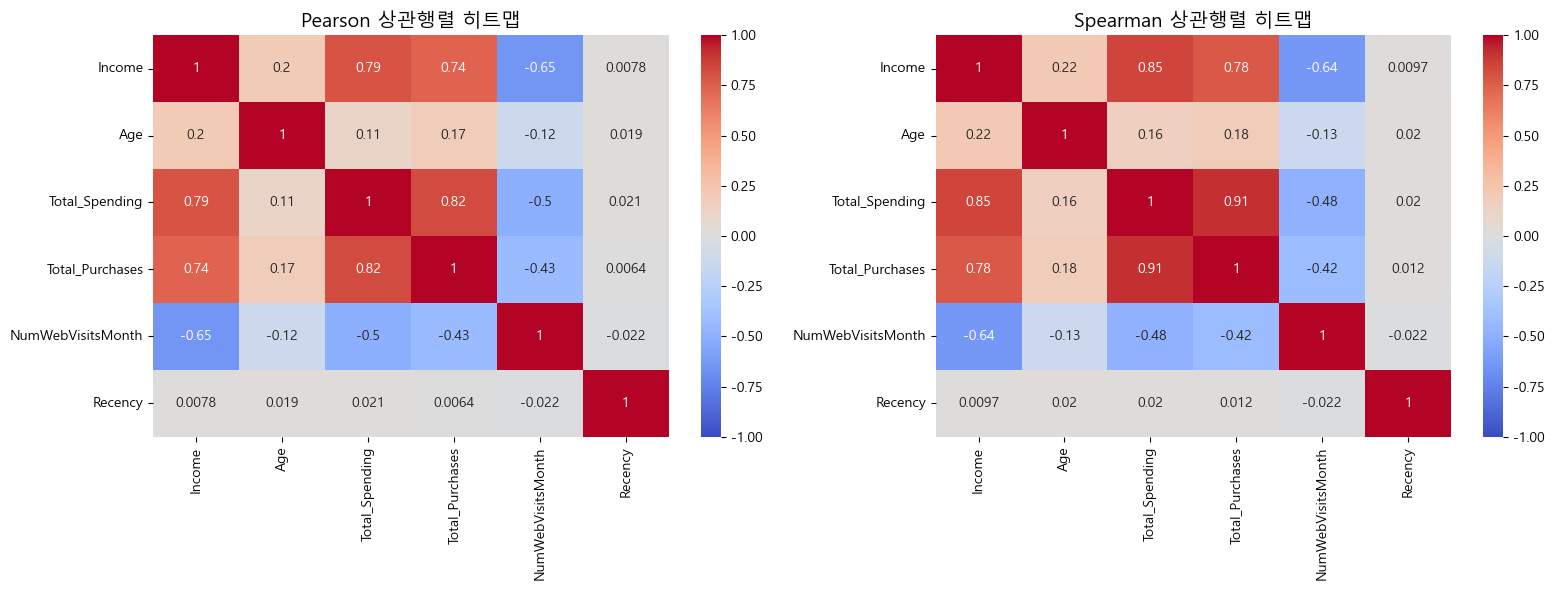

In [178]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Pearson 상관행렬 히트맵', fontsize=14)
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Spearman 상관행렬 히트맵', fontsize=14)
plt.tight_layout()
plt.show()

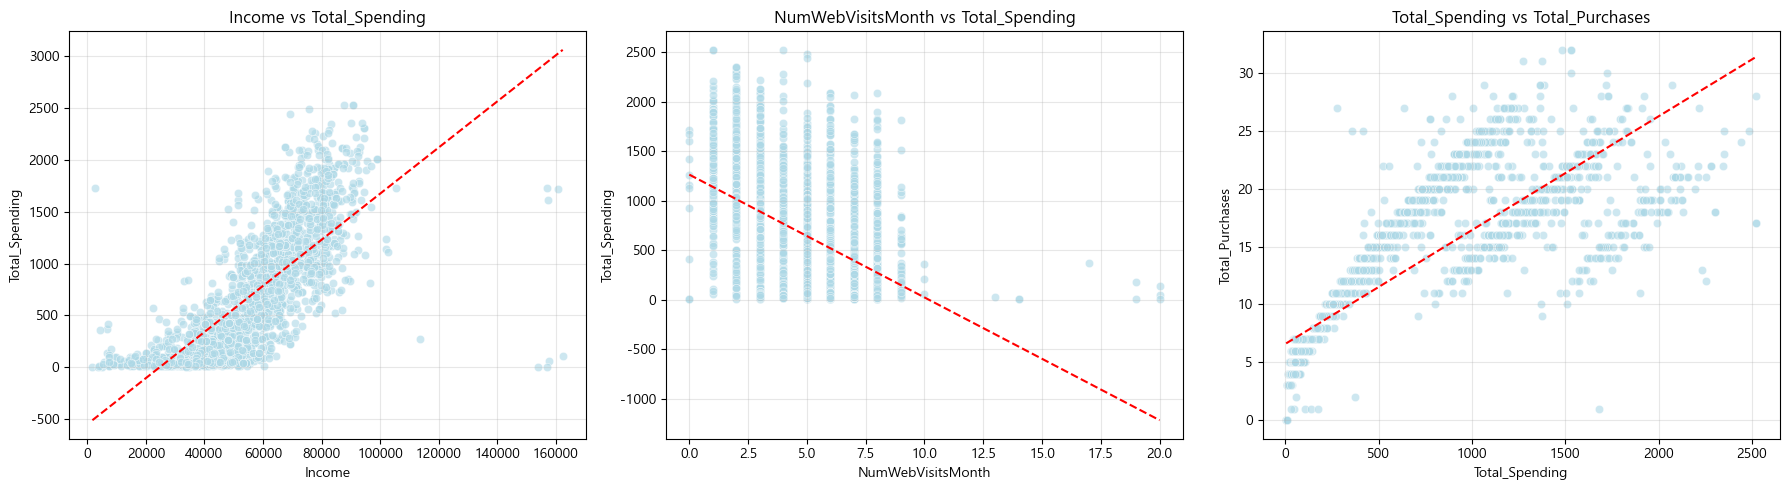

In [179]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요
pairs = [('Income', 'Total_Spending'), 
         ('NumWebVisitsMonth', 'Total_Spending'), 
         ('Total_Spending', 'Total_Purchases')]

plt.figure(figsize=(18, 5))
for i, (x_var, y_var) in enumerate(pairs):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df[x_var], y=df[y_var], color='lightblue', alpha=0.6)
    
    # 추세선 계산
    coeffs = np.polyfit(df[x_var], df[y_var], deg=1)
    trendline = np.poly1d(coeffs)
    x_range = np.linspace(df[x_var].min(), df[x_var].max(), 100)
    plt.plot(x_range, trendline(x_range), color='red', linestyle='--')
    
    plt.title(f'{x_var} vs {y_var}', fontsize=12)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [199]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
z_stat, z_p = proportions_ztest([conv_a, conv_b], [n_a, n_b])
print(f"z-통계량: {z_stat}")
print(f"p-value: {z_p}")

verdict_ab = '\nH₀ 기각: 캠패인 반응 유무에 따라 마지막 캠페인 수락률에 유의한 차이가 있다' if z_p < 0.05 else 'H₀ 기각 실패: 유의한 차이가 없다'
print(f"검정 결과: {verdict_ab}")

# TODO 5-2(b): Cohen's h 효과 크기
h = proportion_effectsize(rate_a, rate_b)
size_h = '매우 작은' if abs(h) < 0.2 else '작은' if abs(h) < 0.5 else '중간' if abs(h) < 0.8 else '큰'
print(f"\n[효과크기] Cohen's h = {abs(h):.4f} ({size_h} 효과)")

# TODO 5-2(c): Wilson 신뢰구간
ci_b = proportion_confint(conv_b, n_b, method='wilson')
print(f"\n[Wilson 신뢰구간] \n이전 캠페인 반응 경험 보유한 그룹의 수락률 95% CI: [{ci_b}]")
ci_a = proportion_confint(conv_a, n_a, method='wilson')
print(f"이전 캠페인 무반응 그룹의 수락률 95% CI: [{ci_a}]")

z-통계량: -17.435692501112072
p-value: 4.4217089462117046e-68
검정 결과: 
H₀ 기각: 캠패인 반응 유무에 따라 마지막 캠페인 수락률에 유의한 차이가 있다

[효과크기] Cohen's h = 0.8016 (큰 효과)

[Wilson 신뢰구간] 
이전 캠페인 반응 경험 보유한 그룹의 수락률 95% CI: [(0.3630763884032965, 0.4523114471540749)]
이전 캠페인 무반응 그룹의 수락률 95% CI: [(0.07039586115479846, 0.09600899871214175)]


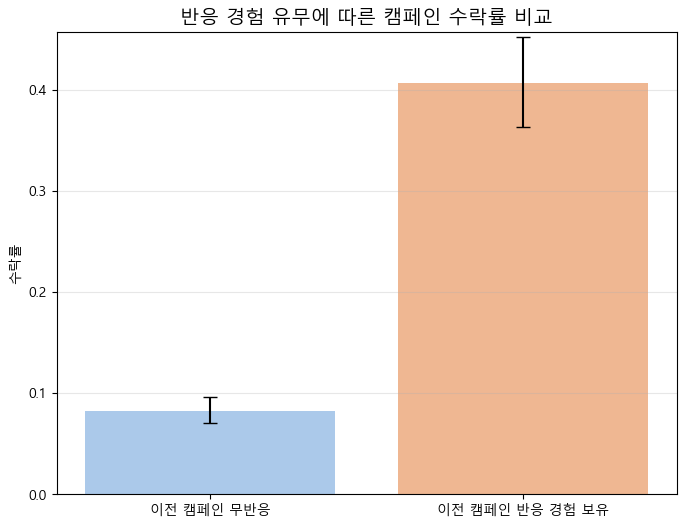

In [201]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
plt.figure(figsize=(8, 6))
sns.barplot(x=['이전 캠페인 무반응', '이전 캠페인 반응 경험 보유'], y=[rate_a, rate_b], palette='pastel', capsize=0.1)
plt.errorbar(x=0, y=rate_a, yerr=[[rate_a - ci_a[0]], [ci_a[1] - rate_a]], fmt='none', c='black', capsize=5)
plt.errorbar(x=1, y=rate_b, yerr=[[rate_b - ci_b[0]], [ci_b[1] - rate_b]], fmt='none', c='black', capsize=5)
plt.title('반응 경험 유무에 따른 캠페인 수락률 비교', fontsize=14)
plt.ylabel('수락률')
plt.ylim(0, max(rate_a, rate_b) + 0.05)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [215]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
h_target = proportion_effectsize(baseline_rate, target_rate)
size_h_target = '매우 작은' if abs(h_target) < 0.2 else '작은' if abs(h_target) < 0.5 else '중간' if abs(h_target) < 0.8 else '큰'
print(f"Cohen's h for 2% increase: {h_target:.4f} ({size_h_target} 효과)")

# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_analysis = NormalIndPower()
required_n = power_analysis.solve_power(
    effect_size=h_target,
    alpha=0.05,
    power=0.80,
    alternative='larger'
)

required_n_final = int(np.ceil(required_n))
print(f"필요 표본 크기: {required_n_final}")

Cohen's h for 2% increase: -0.0547 (매우 작은 효과)


TypeError: only 0-dimensional arrays can be converted to Python scalars

---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛